# Training Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


## Network design

การเทรน network คือการหา network parameter (weight, bias) ที่ดีที่สุด (ทำให้ network มี loss function ต่ำสุด)

สรุปขั้นตอนการสร้าง neural network
1. Data pre-processing
    - ควร normalise/standardise ข้อมูล เพราะจะทำให้ converge เร็วขึ้น
    - EDA อาจทำได้ยากหากข้อมูลเป็นภาพ เราอาจดู statistics ของ pixel value แทน เช่น min, max, mean, std
2. เทรน network ที่มี hyperparameter ชุดต่าง ๆ โดยใช้ training set
    - เราต้องสุ่มค่า weight ต่าง ๆ ขึ้นมา แล้ว update ค่าเหล่านี้เพื่อให้ network มี loss function ($J$) น้อยลงจนต่ำสุดโดยการทำ gradient descent
3. วัด network performance โดยใช้ validation set
    - หาก validation accuracy ต่ำกว่า training accuracy แสดงว่าเราได้ overfitting network วิธีการหนึ่งที่แก้ overfitting ได้ คือ regularisation
        - Explicit regulariser เพิ่มพจน์หนึ่งเข้าไปใน loss function เช่น $L_1$, $L_2$
        - Implicit regulariser เช่น
            - <b>Dropout</b>: เอา neuron บางส่วนใน input หรือ hidden layer ออก
            - <b>Data augmentation</b>:
                - เพิ่มปริมาณข้อมูลใน dataset โดยสร้างข้อมูลใหม่จากข้อมูลที่มีใน dataset นั้น
                - สำหรับ image dataset วิธีการที่ทำได้ เช่น หมุนภาพ เลื่อนภาพ สะท้อนภาพ crop ภาพ zoom ภาพ เพิ่ม noise ปรับความสว่าง เป็นต้น
            - <b>Batch normalisation</b>: Normalise output จาก neuron ก่อนหรือหลังผ่าน activation function ก็ได้ (มักจะทำหลังผ่าน activation function)
            
<img src="../images/implicit_regularisers.png" width="1000" /><br />

4. ทำ hyperparameter tuning แล้วใช้ hyperparameter ชุดที่ดีที่สุดกับ network
5. เทรน network ใหม่โดยใช้ training set กับ validation set รวมกัน
6. ทดสอบ network ด้วย test set
    - <b>Generalisation</b> คือความสามารถของ model ในการใช้ unseen (test) data
    
## Simple feed-forward networks (FFNs)

Feed-forward networks เป็น neural network ที่มีข้อมูลไหลไปทางเดียว

<img src="../images/FFN.png" width="700" /><br />

<b>Forward pass</b> คือการแปลง input เป็น output

<b>Backward pass</b> คือการส่ง error ของ output จาก output layer ย้อนกลับไป input layer เพื่อคำนวณ gradient สำหรับ update ค่า parameter ต่าง ๆ ระหว่างทำ gradient descent

## Training workflow

เมื่อเราได้ train set และ data loader ที่สร้างจาก train set มาแล้ว เราก็สามารถเริ่มเทรน network ได้เลย
- แบ่ง train set ออกเป็น train set กับ validation set
- เมื่อมี train set กับ validation set แล้ว เราต้องมี data loader สำหรับข้อมูลทั้งสองชุดนี้
- สร้าง network
    - Class ของ neural network ต้องสืบทอดจาก `torch.nn.Module` และมี `forward` method
    - หากต้องการทำ <span style="color: #32a852">binary classification</span> เราจะใช้ <span style="color: #32a852">sigmoid</span> เป็น activation function ใน output layer
    - หากต้องการทำ <span style="color: #32a852">multiclass classification</span> เราจะใช้ <span style="color: #32a852">softmax</span> เป็น activation function ใน output layer
- เอาข้อมูล batch แรกมาทำ forward pass $\rightarrow$ คำนวณ loss $\rightarrow$ backward pass $\rightarrow$ optimization step $\rightarrow$ ทำซ้ำกับ batch ต่อ ๆ ไปจนครบ epoch
    - สำหรับ classification เราจะใช้ cross entropy loss (`torch.nn.CrossEntropyLoss(<output>, <target>)`) เป็น loss function
    - Optimizer มีหน้าที่หาทิศทางของ gradient ใน loss space แต่ไม่ได้หน้าที่คำนวณ gradient ในขณะที่ gradient จะถูกคำนวณด้วย `<loss>.backward()`
    - Optimizer ที่นิยมใช้ เช่น
        - SGD with momentum (`torch.optim.SGD(params=<model>.parameters(), lr=<learning_rate>, momentum=<momentum>)`)
        - Adam (`torch.optim.Adam(params=<model>.parameters(), lr=<learning_rate>)`) ดีกว่า

In [4]:
# Download the MNIST dataset
train_set = MNIST("../data", download=True, train=True)
test_set = MNIST("../data", download=True, train=False)

In [5]:
# Split the data
shuffler = StratifiedShuffleSplit(
    n_splits=1, test_size=0.1, random_state=42
).split(train_set.train_data, train_set.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [6]:
# Convert the tensor to a floating-point data type
train_data_tensor = train_set.train_data.to(torch.float32)
# Calculate min, max, mean and std
min_value = train_data_tensor.min()
max_value = train_data_tensor.max()
mean = torch.mean(train_data_tensor/255)
std = torch.std(train_data_tensor/255)
print(f"min = {min_value}\nmax = {max_value}\nmean = {mean}\nstd = {std}")

min = 0.0
max = 255.0
mean = 0.13066047430038452
std = 0.30810782313346863


In [7]:
# Standardise the data
standardise = lambda X: ((X/255)-mean)/std
X_train = standardise(train_set.train_data[indices[0]].float())
y_train = train_set.train_labels[indices[0]]
X_val = standardise(train_set.train_data[indices[1]].float())
y_val = train_set.train_labels[indices[1]]
X_test = standardise(test_set.test_data.float())
y_test = test_set.test_labels

In [8]:
# Create the TensorDatasets containing train, validation and test sets
train_set = TensorDataset(X_train, y_train.long())
val_set = TensorDataset(X_val, y_val.long())
test_set = TensorDataset(X_test, y_test.long())

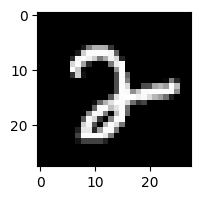

In [9]:
# Plot the first image of the training set
img = X_train[0]
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(img, cmap='gray');

In [10]:
# The size of images
print(img.shape)

torch.Size([28, 28])


In [11]:
# The number of pixels of an image
num_pixels = 28*28

In [12]:
class simpleFFN(nn.Module):
    """Simple feed-forward network."""
    def __init__(self):
        super(simpleFFN, self).__init__()
        self.hidden_1 = nn.Linear(num_pixels, 200, bias=False)  # รับ 784 ค่า ผ่าน hidden layer ที่ 1 ได้ออกมา 200 ค่า
        self.hidden_2 = nn.Linear(200, 50, bias=False)  # รับ 200 ค่า ผ่าน hidden layer ที่ 2 ได้ออกมา 50 ค่า
        self.output = nn.Linear(50, 10, bias=False)  # รับ 50 ค่า ผ่าน hidden layer ที่ 3 ได้ออกมา 10 ค่า
        self.activation = nn.Sigmoid()

    def forward(self, X):
        z1 = self.hidden_1(X.flatten(start_dim=1))
        a1 = self.activation(z1)
        z2 = self.hidden_2(a1)
        a2 = self.activation(z2)
        z3 = self.output(a2)
        a3 = self.activation(z3)
        return a3

x = torch.randn((1, 1, num_pixels))  # Dummy input
model = simpleFFN()
y = model(x)
print(y)
print(model)

tensor([[0.6003, 0.4514, 0.5373, 0.5035, 0.5261, 0.5614, 0.5763, 0.3399, 0.5015,
         0.6127]], grad_fn=<SigmoidBackward0>)
simpleFFN(
  (hidden_1): Linear(in_features=784, out_features=200, bias=False)
  (hidden_2): Linear(in_features=200, out_features=50, bias=False)
  (output): Linear(in_features=50, out_features=10, bias=False)
  (activation): Sigmoid()
)


In [13]:
# Show the summary of the information about the mode
summ = summary(model, x.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         156,800
           Sigmoid-2                  [-1, 200]               0
            Linear-3                   [-1, 50]          10,000
           Sigmoid-4                   [-1, 50]               0
            Linear-5                   [-1, 10]             500
           Sigmoid-6                   [-1, 10]               0
Total params: 167,300
Trainable params: 167,300
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 0.65
----------------------------------------------------------------


In [14]:
def train(model, optimizer, criterion, data_loader):
    model.train()                                    # Turn on training mode

    # Loop over the mini-batches defined in the data loader to sum loss and accuracy
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:              
        X, y = X.to(device), y.to(device)            # Send data to the device
        optimizer.zero_grad()                        # Reset the information of the optimiser 
        a2 = model(X.view(-1, num_pixels))           # Forward pass
        loss = criterion(a2, y)                      # Compute loss
        loss.backward()                              # Backward pass
        train_loss += loss*X.size(0)                 # Add loss
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # Get predictions
        train_accuracy += accuracy_score(
            y.cpu().numpy(),
            y_pred.detach().cpu().numpy()
        )*X.size(0)                                  # Compute accuracy
        optimizer.step()                             # Perform a step of gradient descent

    # Average the loss and accuracy over the whole training set
    avg_train_loss = train_loss/len(data_loader.dataset)
    avg_train_accuracy = train_accuracy/len(data_loader.dataset)
    return avg_train_loss, avg_train_accuracy

def validate(model, criterion, data_loader):
    model.eval()                                         # Turn on evaluation mode

    # Loop over the mini-batches defined in the data loader to sum loss and accuracy
    val_loss, val_accuracy = 0, 0
    for X, y in data_loader:
        with torch.no_grad():                            # Deactivate autograd engine
            X, y = X.to(device), y.to(device)            # Send data to the device
            a2 = model(X.view(-1, num_pixels))           # Forward pass
            loss = criterion(a2, y)                      # Compute loss
            val_loss += loss*X.size(0)                   # Add loss
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # Get predictions
            val_accuracy += accuracy_score(
                y.cpu().numpy(),
                y_pred.cpu().numpy()
            )*X.size(0)                                  # Compute accuracy

    # Average the loss and accuracy over the whole validation set
    avg_val_loss = val_loss/len(data_loader.dataset)
    avg_val_accuracy = val_accuracy/len(data_loader.dataset)
    return avg_val_loss, avg_val_accuracy

def evaluate(model, data_loader):
    model.eval()                                         # Turn on evaluation mode
    
    # Loop over the mini-batches defined in the data loader to store true and predicted labels
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)            # Send data to the device
            a2 = model(X.view(-1, num_pixels))           # Forward pass
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # Get prediction
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    # Concatenate the labels of each batch into a single list
    return np.concatenate(ys, 0), np.concatenate(y_preds, 0)

In [15]:
# Choose the hyperparameter of our network
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [16]:
set_seed(seed)
model = simpleFFN().to(device)                    # Instantiate a network and send it to the device
optimizer = torch.optim.SGD(                      # Instantiate an optimizer
    model.parameters(), lr=lr, momentum=momentum
)
criterion = nn.CrossEntropyLoss()                 # Loss function

In [17]:
# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [18]:
# Test model input and output sizes with batch sample
x = next(iter(train_loader))[0].to(device)
y = model(x).to(device)
print(x.shape)
print(y.shape)

torch.Size([64, 28, 28])
torch.Size([64, 10])


In [19]:
# Compute log loss and accuracy of the model and plot them over epoches
# You can use the "livelossplot" module to plot a real-time evolution of loss and accuracy 
set_seed(seed)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_loss, val_accuracy = validate(model, criterion, val_loader)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

KeyboardInterrupt: 

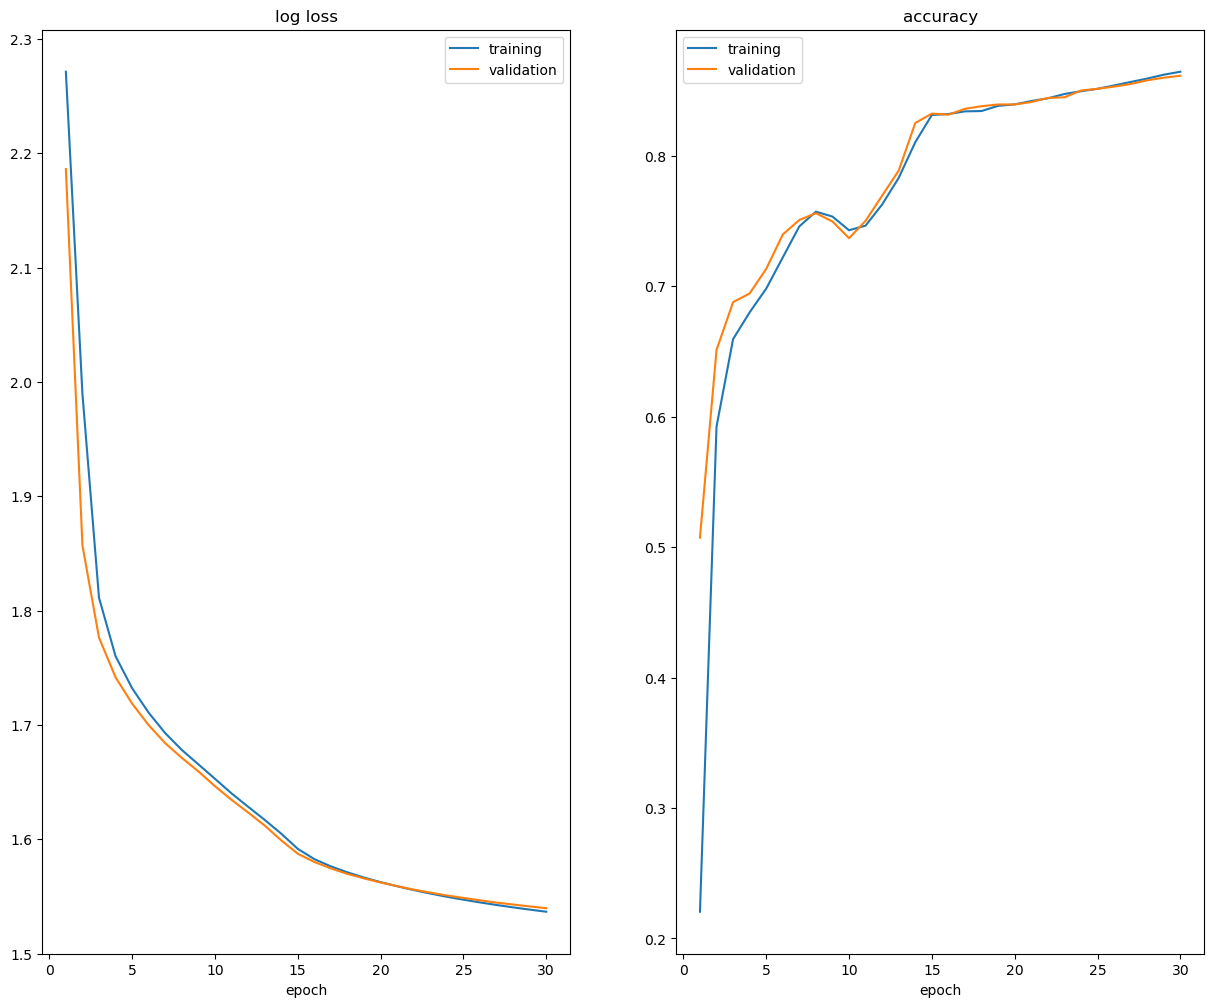

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].plot(range(1, n_epochs+1), train_losses, label="training")
axes[0].plot(range(1, n_epochs+1), val_losses, label="validation")
axes[0].set(title="log loss", xlabel="epoch")
axes[0].legend()
axes[1].plot(range(1, n_epochs+1), train_accuracies, label="training")
axes[1].plot(range(1, n_epochs+1), val_accuracies, label="validation")
axes[1].set(title="accuracy", xlabel="epoch")
axes[1].legend();

In [42]:
# Use the validation set to predict labels
ys, y_preds, = evaluate(model, val_loader)
pd.DataFrame({"True": ys, "Predicted": y_preds})

,True,Predicted
0,1,1
1,9,9
2,3,3
3,4,9
4,6,6
...,...,...
5995,4,9
5996,1,1
5997,5,2
5998,0,0


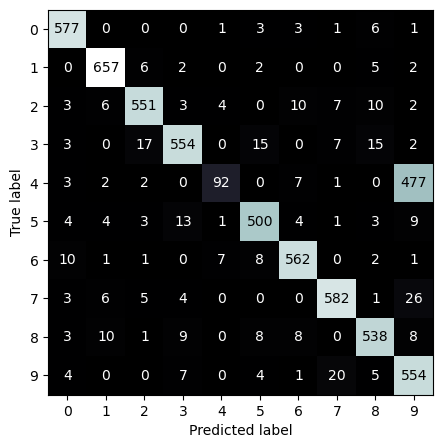

In [43]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(ys, y_preds, ax=ax, colorbar=False, cmap='bone');